In [2]:
# Load libraries
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
import tensorflow
import sklearn
import keras
import yfinance as yf



from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor



#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.optimizers import SGD
from keras.src.layers import LSTM, Dense


from scikeras.wrappers import KerasRegressor

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

# Time series Models

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression


#Plotting
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf


In [3]:
stk_tickers = ['MSFT', 'IBM', 'GOOGL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']

# Extraction des données boursières pour les actions
try:
    stk_data = yf.download(stk_tickers, start="2020-01-01", end="2023-01-01")
    print("Données boursières téléchargées :")
    print(stk_data.head())
except Exception as e:
    print(f"Erreur lors de l'extraction des données boursières : {e}")

# Remarque : Pour FRED, utiliser pandas_datareader comme pour DEXJPUS ou d'autres données économiques
from pandas_datareader import data as web

try:
    ccy_data = web.DataReader(ccy_tickers, 'fred')
    idx_data = web.DataReader(idx_tickers, 'fred')
    print("Données FRED téléchargées :")
    print(ccy_data.head())
    print(idx_data.head())
except Exception as e:
    print(f"Erreur lors de l'extraction des données de FRED : {e}")

return_period = 5

Y = np.log(stk_data.loc[:, ('Volume', 'MSFT')]).diff(return_period).shift(-return_period)
Y.name = Y.name[-1]+'_pred'

X1 = np.log(stk_data.loc[:, ('Volume', ('GOOGL', 'IBM'))]).diff(return_period)
X1.columns = X1.columns.droplevel()
X2 = np.log(ccy_data).diff(return_period)
X3 = np.log(idx_data).diff(return_period)

X4 = pd.concat([np.log(stk_data.loc[:, ('Volume', 'MSFT')]).diff(i) for i in [return_period, return_period*3, return_period*6, return_period*12]], axis=1).dropna()
X4.columns = ['MSFT_DT', 'MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT']

X = pd.concat([X1, X2, X3, X4], axis=1)

dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
Y = dataset.loc[:, Y.name]
X = dataset.loc[:, X.columns]

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  3 of 3 completed


Données boursières téléchargées :
Price           Close                               High              \
Ticker          GOOGL         IBM        MSFT      GOOGL         IBM   
Date                                                                   
2020-01-02  68.108368  101.918839  153.323242  68.108368  102.295145   
2020-01-03  67.752075  101.106049  151.414154  68.360669  101.497407   
2020-01-06  69.557945  100.925423  151.805481  69.583321  101.030782   
2020-01-07  69.423584  100.993134  150.421402  69.841090  101.572651   
2020-01-08  69.917732  101.836075  152.817352  70.256612  102.250016   

Price                         Low                               Open  \
Ticker            MSFT      GOOGL         IBM        MSFT      GOOGL   
Date                                                                   
2020-01-02  153.428246  67.004150  101.429641  151.137280  67.099694   
2020-01-03  152.683736  67.045454  100.519005  150.879596  67.079297   
2020-01-06  151.872308  67.22

In [4]:
print(stk_data.columns)

MultiIndex([( 'Close', 'GOOGL'),
            ( 'Close',   'IBM'),
            ( 'Close',  'MSFT'),
            (  'High', 'GOOGL'),
            (  'High',   'IBM'),
            (  'High',  'MSFT'),
            (   'Low', 'GOOGL'),
            (   'Low',   'IBM'),
            (   'Low',  'MSFT'),
            (  'Open', 'GOOGL'),
            (  'Open',   'IBM'),
            (  'Open',  'MSFT'),
            ('Volume', 'GOOGL'),
            ('Volume',   'IBM'),
            ('Volume',  'MSFT')],
           names=['Price', 'Ticker'])


In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
type(dataset)

pandas.core.frame.DataFrame

In [7]:
def series_to_supervised(data, lag=1):
    n_vars = data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(lag, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (df.columns[j], i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    agg = pd.DataFrame(data.iloc[:,0]).join(agg)
    agg.dropna(inplace=True)
    return agg

In [8]:
dataset= series_to_supervised(dataset,1)

In [9]:
# shape
dataset.shape

(123, 13)

In [10]:
# peek at data
pd.set_option('display.width', 100)
dataset.head(2)

,MSFT_pred,MSFT_pred(t-1),GOOGL(t-1),IBM(t-1),DEXJPUS(t-1),DEXUSUK(t-1),SP500(t-1),DJIA(t-1),VIXCLS(t-1),MSFT_DT(t-1),MSFT_3DT(t-1),MSFT_6DT(t-1),MSFT_12DT(t-1)
2020-05-21,0.369362,-0.363255,0.178988,0.175553,0.006840,-0.012631,-0.010008,-0.010549,0.036538,0.391236,0.244515,-0.325261,0.333549
2020-05-29,-0.054554,0.369362,-0.171124,-0.273498,0.005587,0.002703,0.033104,0.035296,-0.099212,-0.363255,-0.615275,-0.506400,-0.657617


In [11]:
# types
pd.set_option('display.max_rows', 500)
dataset.dtypes

MSFT_pred         float64
MSFT_pred(t-1)    float64
GOOGL(t-1)        float64
IBM(t-1)          float64
DEXJPUS(t-1)      float64
DEXUSUK(t-1)      float64
SP500(t-1)        float64
DJIA(t-1)         float64
VIXCLS(t-1)       float64
MSFT_DT(t-1)      float64
MSFT_3DT(t-1)     float64
MSFT_6DT(t-1)     float64
MSFT_12DT(t-1)    float64
dtype: object

In [12]:
pd.set_option('display.precision', 3)
dataset = pd.DataFrame(dataset)
print(dataset.describe())

       MSFT_pred  MSFT_pred(t-1)  GOOGL(t-1)  IBM(t-1)  DEXJPUS(t-1)  DEXUSUK(t-1)  SP500(t-1)  \
count    123.000         123.000     123.000   123.000     1.230e+02     1.230e+02     123.000   
mean      -0.020          -0.018      -0.011     0.019     1.473e-03    -1.038e-04       0.002   
std        0.365           0.363       0.435     0.523     1.119e-02     1.210e-02       0.026   
min       -0.927          -0.927      -1.121    -1.577    -4.592e-02    -4.459e-02      -0.091   
25%       -0.225          -0.225      -0.267    -0.284    -4.330e-03    -6.726e-03      -0.009   
50%       -0.033          -0.033      -0.028    -0.035     9.783e-04    -3.791e-04       0.001   
75%        0.211           0.211       0.252     0.294     7.401e-03     8.473e-03       0.016   
max        0.908           0.908       1.203     2.010     3.206e-02     4.235e-02       0.062   

       DJIA(t-1)  VIXCLS(t-1)  MSFT_DT(t-1)  MSFT_3DT(t-1)  MSFT_6DT(t-1)  MSFT_12DT(t-1)  
count    123.000      123

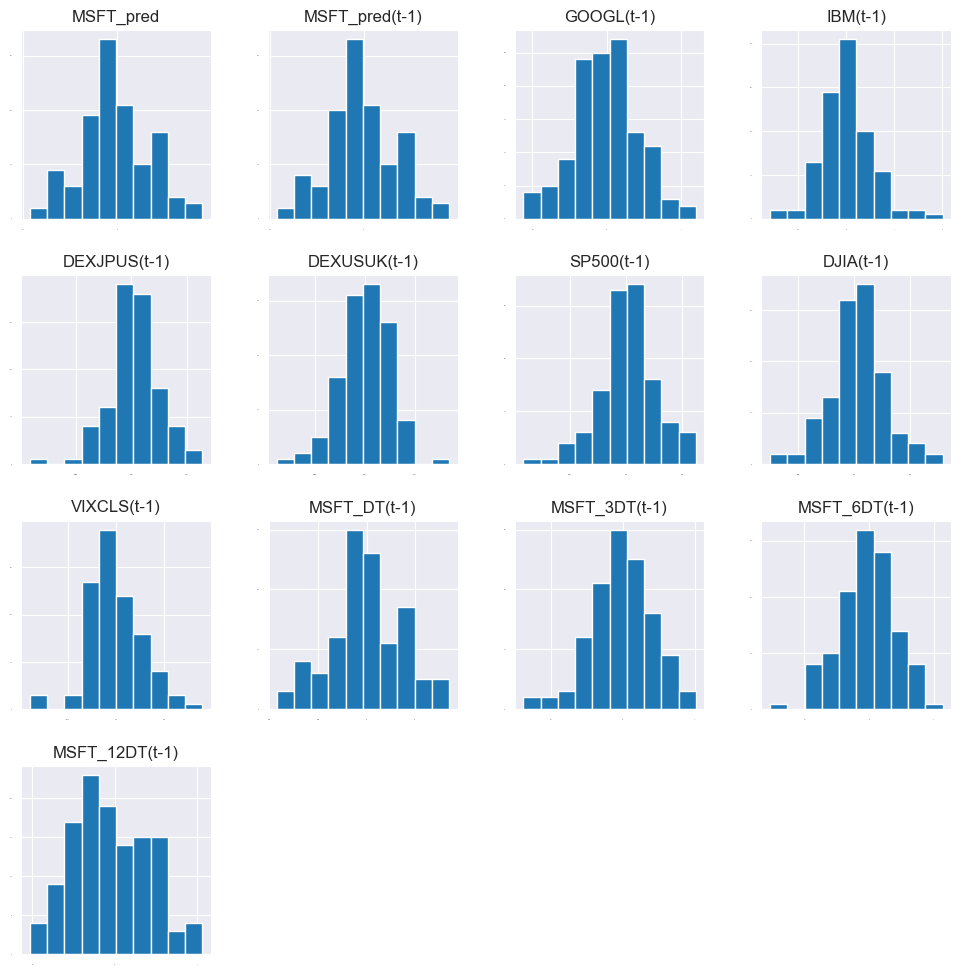

In [13]:
# histograms
dataset.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

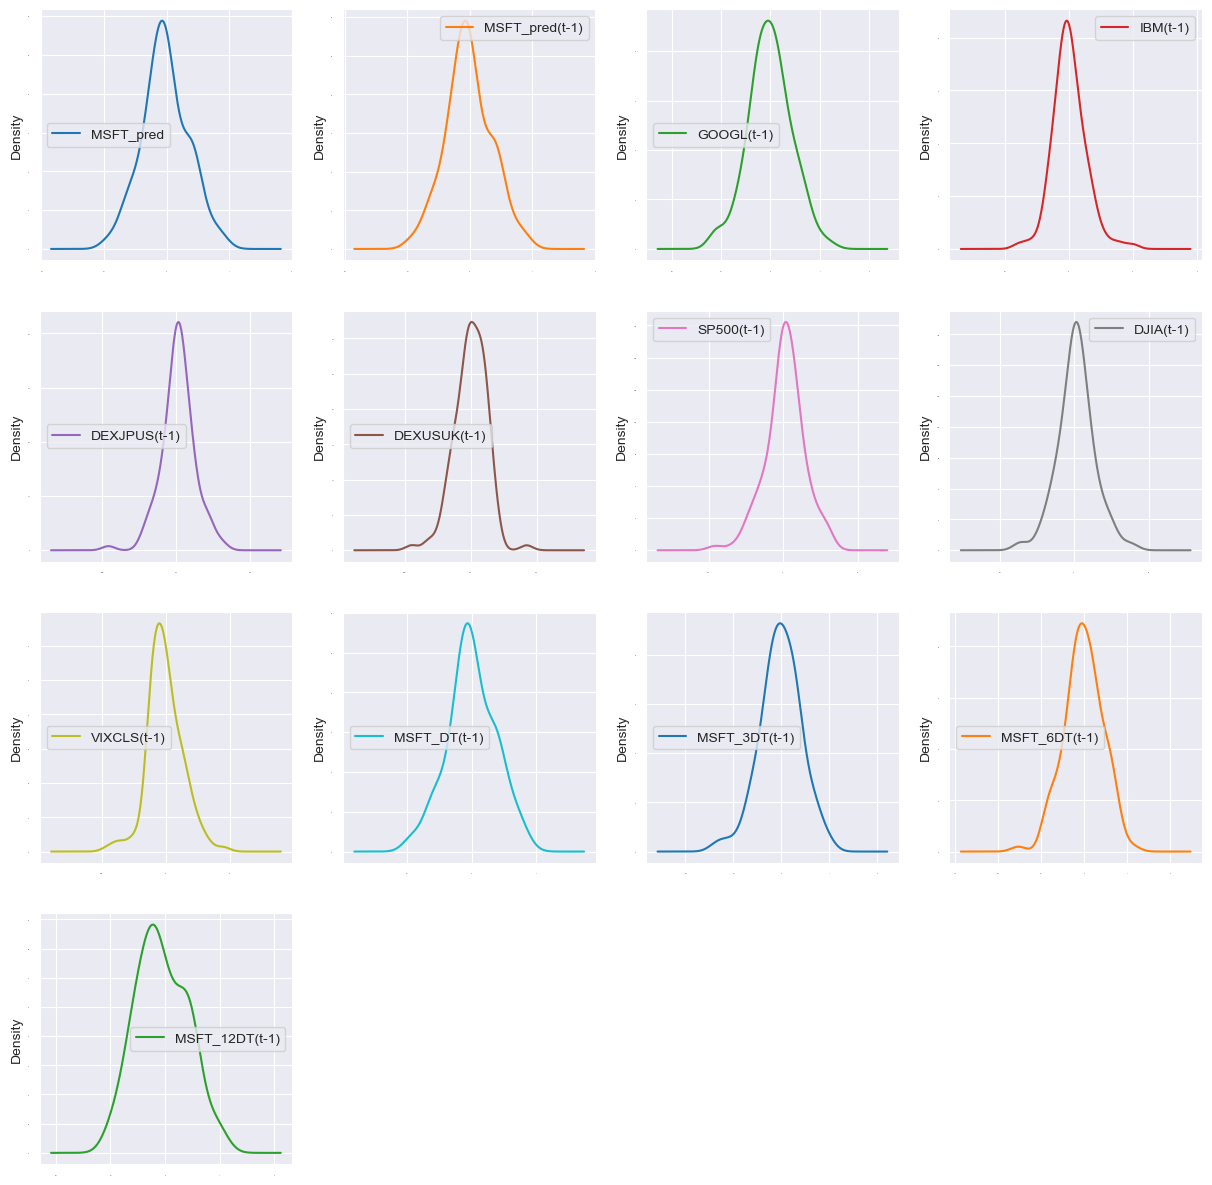

In [14]:
# density
dataset.plot(kind='density', subplots=True, layout=(4,4), sharex=False, legend=True, fontsize=1, figsize=(15,15))
pyplot.show()

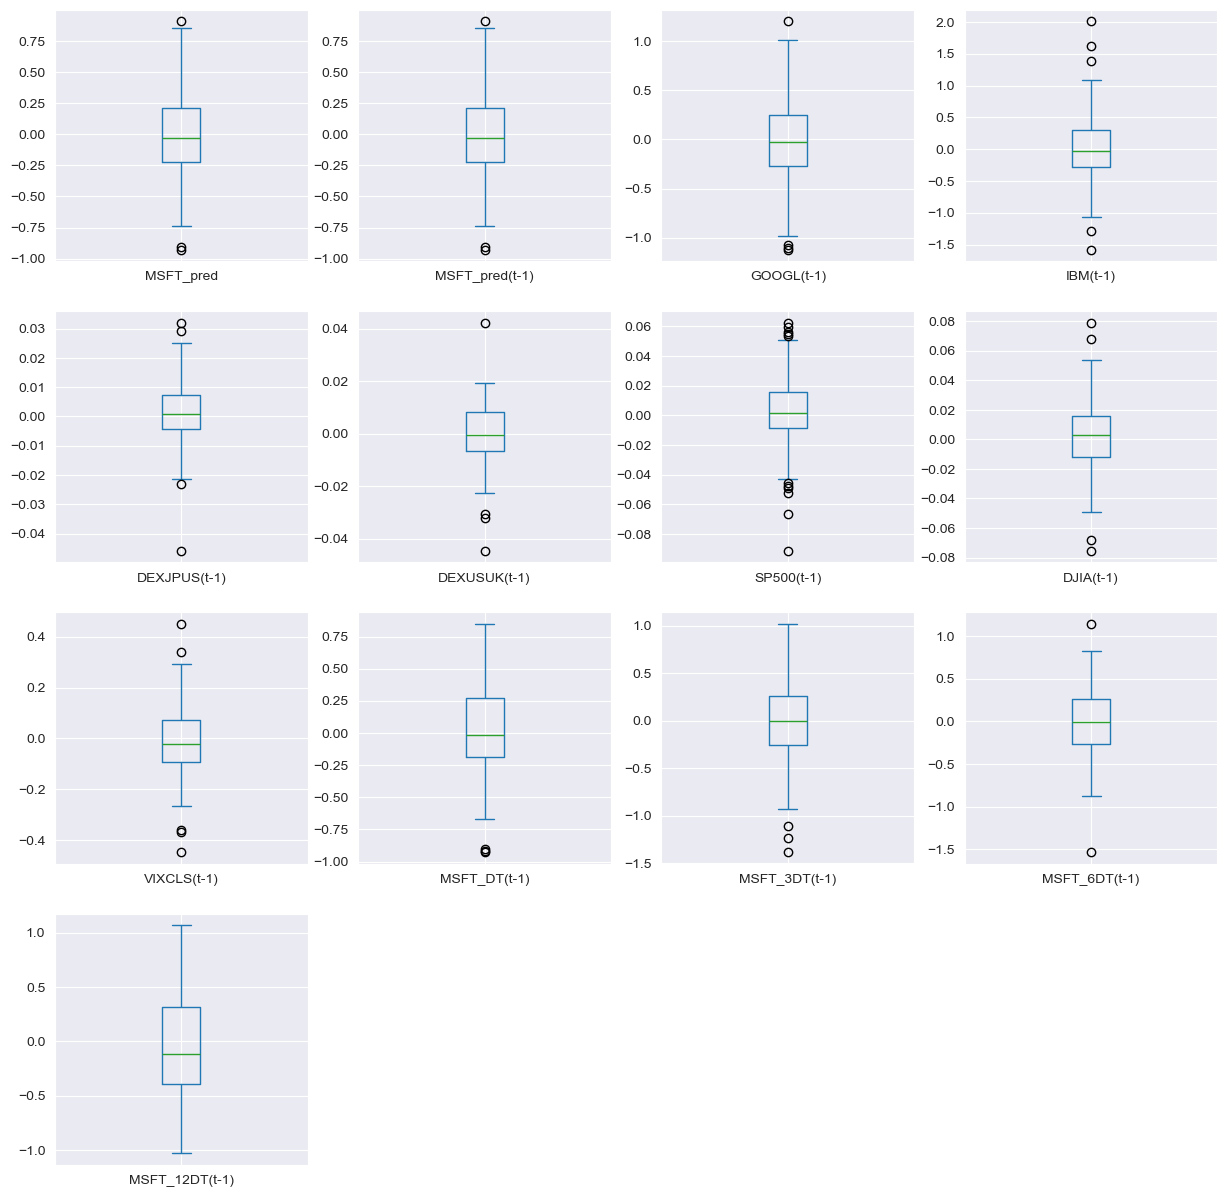

In [15]:
#Box and Whisker Plots
dataset.plot(kind='box', subplots=True, layout=(4,4), sharex=False, sharey=False, figsize=(15,15))
pyplot.show()

<Axes: title={'center': 'Correlation Matrix'}>

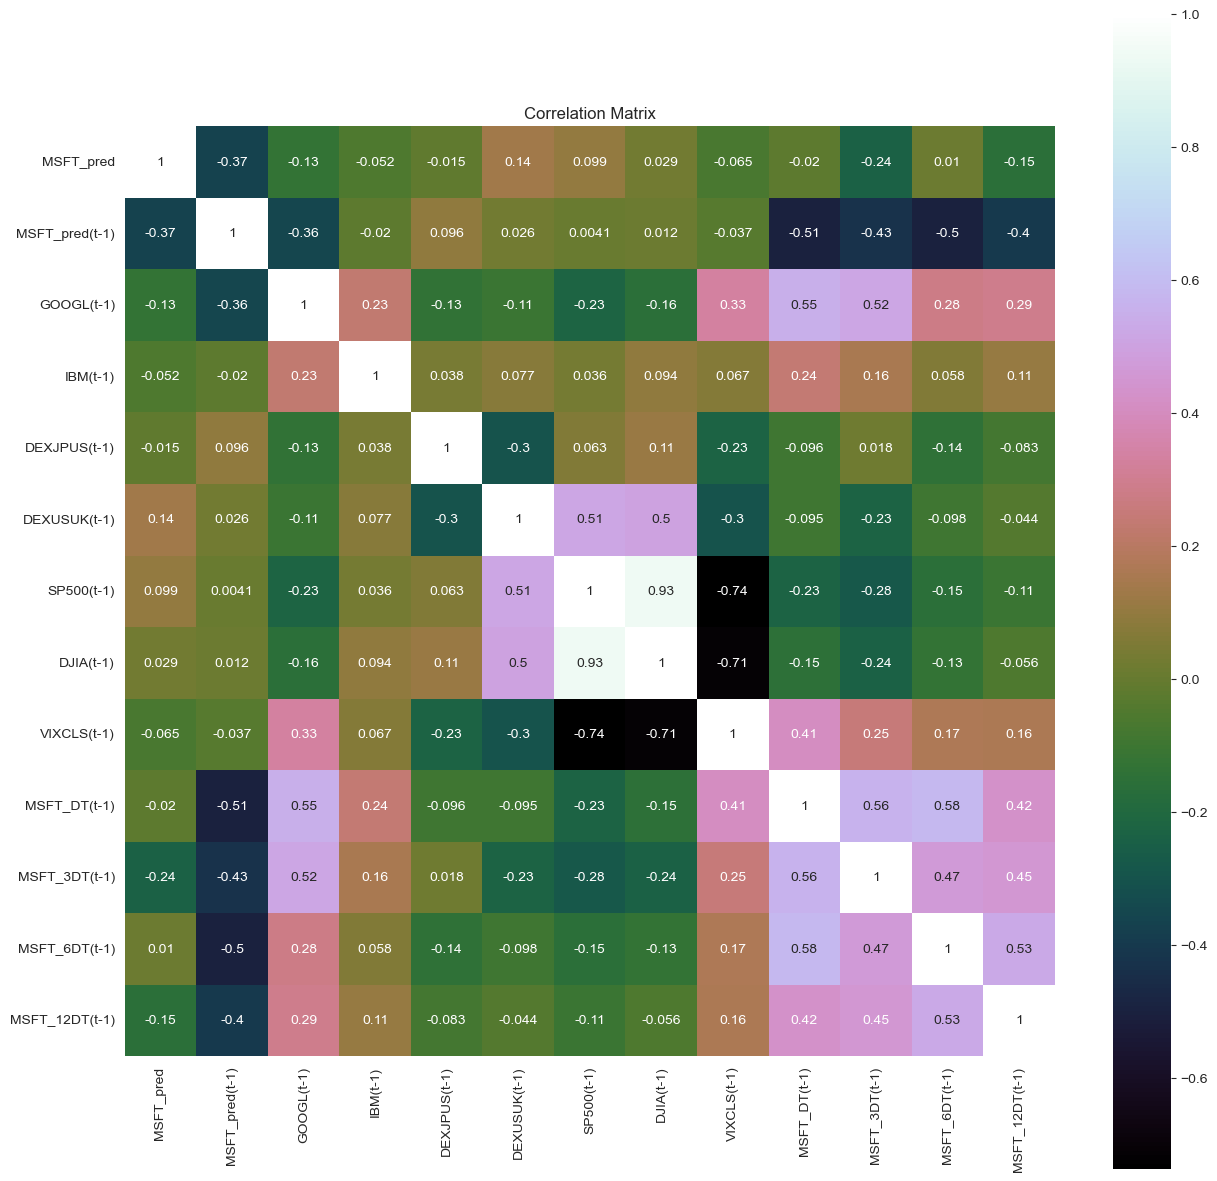

In [16]:
# correlation
correlation = dataset.corr()
pyplot.figure(figsize=(15,15))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

<Figure size 1500x1500 with 0 Axes>

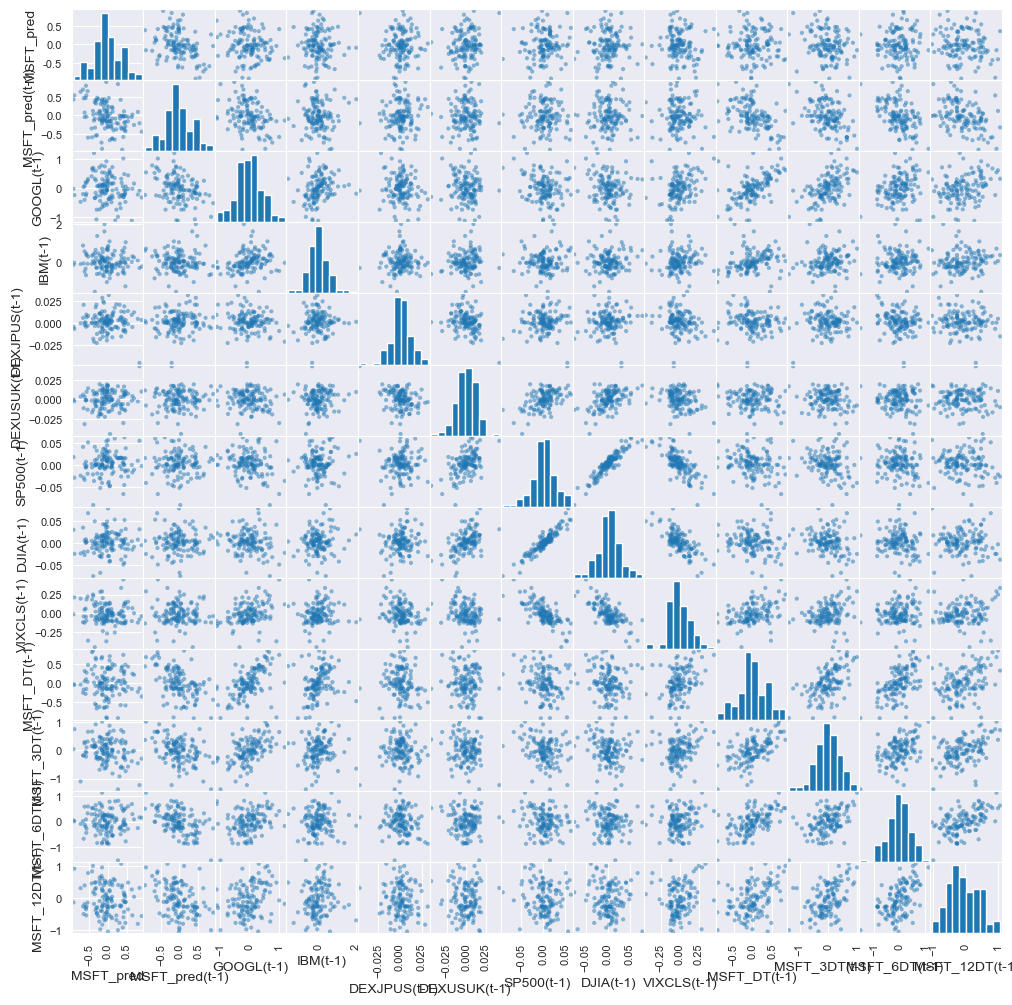

In [17]:
# Scatterplot Matrix
from pandas.plotting import scatter_matrix
pyplot.figure(figsize=(15,15))
scatter_matrix(dataset,figsize=(12,12))
pyplot.show()# Scatterplot Matrix


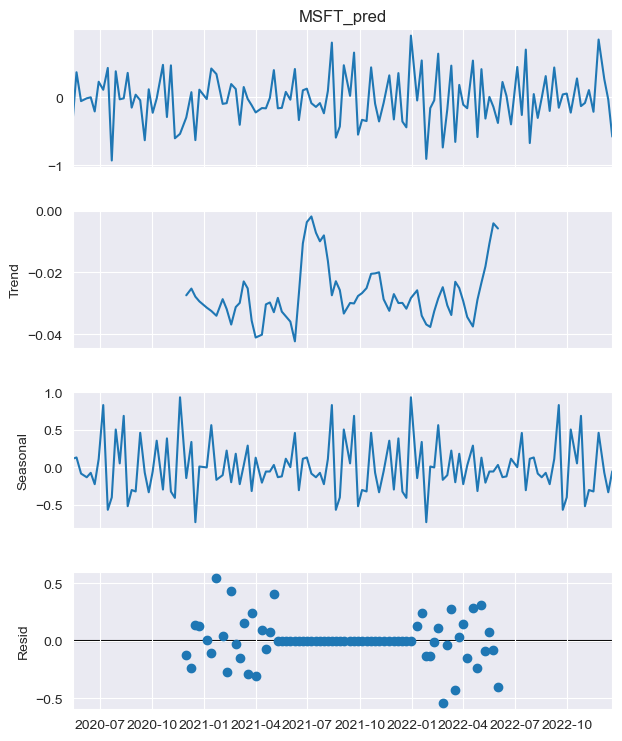

In [18]:


# Supposons que Y soit votre série temporelle définie
res = sm.tsa.seasonal_decompose(Y, period=52)  # Remplacer 'freq' par 'period'
fig = res.plot()
fig.set_figheight(8)

In [19]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())

Null Values = False


In [20]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

bestfeatures = SelectKBest(k=5)
bestfeatures

SelectKBest(k=5)

In [21]:
type(dataset)

pandas.core.frame.DataFrame

In [22]:
bestfeatures = SelectKBest(k=5, score_func=f_regression)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores.nlargest(10,'Score').set_index('Specs')  #print 10 best features

,Score
Specs,
MSFT_DT,40.587
MSFT_6DT,39.380
MSFT_3DT,27.350
MSFT_12DT,22.406
GOOGL,17.257
DEXJPUS,1.270
DEXUSUK,0.143
DJIA,0.119
VIXCLS,0.092


In [23]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
rescaledX = pd.DataFrame(scaler.fit_transform(X))
# summarize transformed data
rescaledX.head(5)

,0,1,2,3,4,5,6,7,8,9,10
0,0.559,0.489,0.677,0.368,0.529,0.420,0.539,0.742,0.678,0.451,0.650
1,0.409,0.363,0.661,0.544,0.809,0.717,0.388,0.317,0.319,0.384,0.178
2,0.561,0.630,0.621,0.646,0.787,0.726,0.472,0.730,0.741,0.505,0.412
3,0.610,0.614,0.696,0.716,0.959,1.000,0.398,0.738,0.435,0.561,0.000
4,0.437,0.428,0.455,0.375,0.252,0.049,0.818,0.515,0.765,0.504,0.032


In [24]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X)
StandardisedX = pd.DataFrame(scaler.fit_transform(X))
# summarize transformed data
StandardisedX.head(5)

,0,1,2,3,4,5,6,7,8,9,10
0,0.440,0.297,0.487,-1.036,-0.458,-0.513,0.312,1.067,0.604,-0.695,0.838
1,-0.371,-0.568,0.375,0.239,1.199,1.335,-0.691,-0.981,-1.408,-1.105,-1.295
2,0.446,1.277,0.097,0.978,1.065,1.397,-0.131,1.007,0.962,-0.368,-0.240
3,0.714,1.165,0.622,1.482,2.087,3.102,-0.620,1.047,-0.761,-0.031,-2.101
4,-0.220,-0.122,-1.071,-0.981,-2.097,-2.824,2.164,-0.031,1.092,-0.374,-1.954


In [25]:
from sklearn.preprocessing import Normalizer
scaler = Normalizer().fit(X)
NormalizedX = pd.DataFrame(scaler.fit_transform(X))
# summarize transformed data
NormalizedX.head(5)

,0,1,2,3,4,5,6,7,8,9,10
0,0.255,0.250,0.010,-0.018,-0.014,-0.015,0.052,0.556,0.348,-0.463,0.474
1,-0.149,-0.238,0.005,0.002,0.029,0.031,-0.086,-0.317,-0.536,-0.441,-0.573
2,0.196,0.738,0.003,0.013,0.032,0.040,-0.025,0.399,0.429,-0.195,-0.181
3,0.220,0.463,0.006,0.013,0.042,0.059,-0.066,0.284,-0.251,-0.023,-0.764
4,-0.094,-0.037,-0.009,-0.011,-0.047,-0.060,0.255,-0.012,0.402,-0.163,-0.855


In [26]:
validation_size = 0.2

#In case the data is not dependent on the time series, then train and test split randomly
seed = 7
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

#In case the data is not dependent on the time series, then train and test split should be done based on sequential sample
#This can be done by selecting an arbitrary split point in the ordered list of observations and creating two new datasets.
#train_size = int(len(X) * (1-validation_size))
#X_train, X_test = X[0:train_size], X[train_size:len(X)]
#Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

In [27]:
# test options for regression
num_folds = 10
scoring = 'neg_mean_squared_error'
#scoring ='neg_mean_absolute_error'
#scoring = 'r2'

In [28]:
# spot check the algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))
#Neural Network
models.append(('MLP', MLPRegressor()))

In [29]:
#Ensable Models
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

In [30]:
#Running deep learning models and performing cross validation takes time
#Set the following Flag to 0 if the Deep LEarning Models Flag has to be disabled
EnableDeepLearningRegreesorFlag = 0

def create_model(neurons=12, activation='relu', learn_rate = 0.01, momentum=0):
        # create model
        model = Sequential()
        model.add(Dense(neurons, input_dim=X_train.shape[1], activation=activation))
        #The number of hidden layers can be increased
        model.add(Dense(2, activation=activation))
        # Final output layer
        model.add(Dense(1, kernel_initializer='normal'))
        # Compile model
        optimizer = SGD(lr=learn_rate, momentum=momentum)
        model.compile(loss='mean_squared_error', optimizer='adam')
        return model

In [31]:
#Add Deep Learning Regressor
if ( EnableDeepLearningRegreesorFlag == 1):
    models.append(('DNN', KerasRegressor(build_fn=create_model, epochs=100, batch_size=100, verbose=1)))

In [32]:
from sklearn.model_selection import  LeaveOneOut
names = []
kfold_results = []
test_results = []
train_results = []

for name, model in models:
    names.append(name)
    ## K Fold analysis:
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    #converted mean square error to positive. The lower the better
    # Adjuster `num_folds` dynamiquement si nécessaire
    if len(X_train) < num_folds:
        print(f"Réduction du nombre de plis à {len(X_train)}, car le nombre d'échantillons est insuffisant.")
        num_folds = len(X_train)
    # Validation croisée
    if num_folds > 1:
        kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
        cv_results = -1 * cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    else:
        # Option alternative : Leave-One-Out si trop peu d'échantillons
        print("Passage au Leave-One-Out en raison du faible nombre d'échantillons.")
        loo = LeaveOneOut()
        cv_results = -1 * cross_val_score(model, X_train, Y_train, cv=loo, scoring=scoring)

    kfold_results.append(cv_results)

    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)

    # Test results
    res = model.fit(X_train, Y_train)
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)

    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.098041 (0.035808) 0.072084 0.113080
LASSO: 0.141532 (0.044954) 0.140199 0.101586
EN: 0.141532 (0.044954) 0.140199 0.101586
KNN: 0.101021 (0.026847) 0.067356 0.161188
CART: 0.211065 (0.090225) 0.000000 0.133525
SVR: 0.105544 (0.034268) 0.041225 0.156149
MLP: 0.106022 (0.047269) 0.061003 0.112256
ABR: 0.097117 (0.018681) 0.025804 0.140144
GBR: 0.102264 (0.026989) 0.001215 0.160237
RFR: 0.096653 (0.014645) 0.013471 0.133676
ETR: 0.095621 (0.016463) 0.000000 0.128332


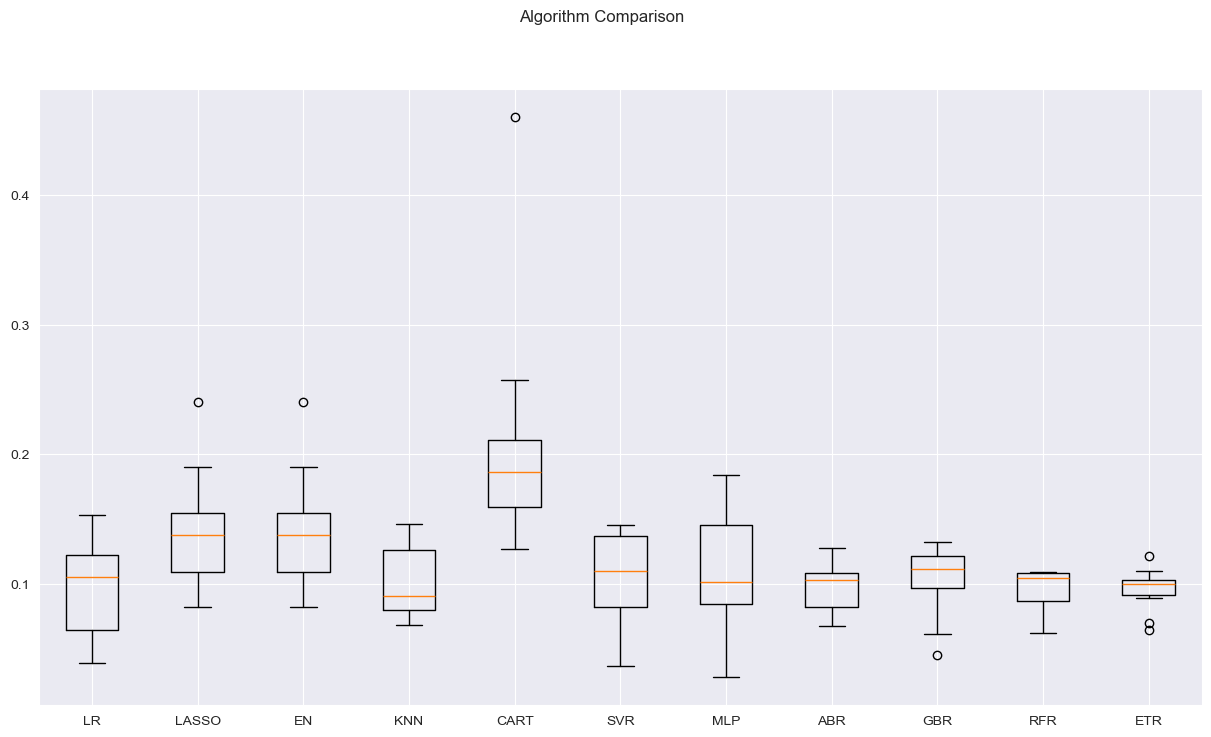

In [33]:
# compare algorithms
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

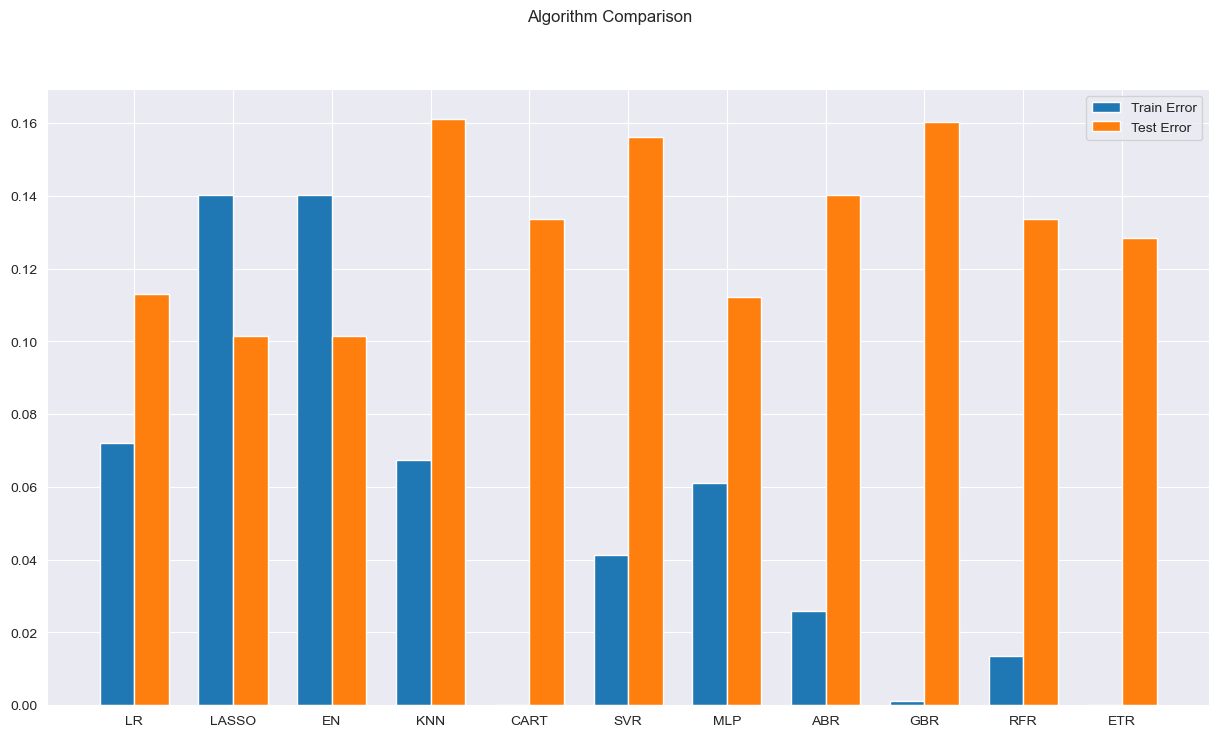

In [34]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

In [35]:
X_train_ARIMA=X_train.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
X_test_ARIMA=X_test.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
tr_len = len(X_train_ARIMA)
te_len = len(X_test_ARIMA)
to_len = len (X)

In [36]:
modelARIMA=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=[1,0,0])
model_fit = modelARIMA.fit()

In [37]:
error_Training_ARIMA = mean_squared_error(Y_train, model_fit.fittedvalues)
predicted = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA)[1:]
error_Test_ARIMA = mean_squared_error(Y_test,predicted)
error_Test_ARIMA

0.12976334840161763

In [38]:
seq_len = 2 #Length of the seq for the LSTM

Y_train_LSTM, Y_test_LSTM = np.array(Y_train)[seq_len-1:], np.array(Y_test)
X_train_LSTM = np.zeros((X_train.shape[0]+1-seq_len, seq_len, X_train.shape[1]))
X_test_LSTM = np.zeros((X_test.shape[0], seq_len, X.shape[1]))
for i in range(seq_len):
    X_train_LSTM[:, i, :] = np.array(X_train)[i:X_train.shape[0]+i+1-seq_len, :]
    X_test_LSTM[:, i, :] = np.array(X)[X_train.shape[0]+i-1:X.shape[0]+i+1-seq_len, :]

In [39]:



# Lstm Network
def create_LSTMmodel(neurons=12, learn_rate = 0.01, momentum=0):
    model = Sequential()

    # Ajoute une couche LSTM avec 50 cellules (neurones) et une forme d'entrée spécifique
    model.add(LSTM(50, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))

    # Ajoute une couche dense (de sortie avec activation linéaire par défaut ici)
    model.add(Dense(1))

    # Configure l'optimiseur SGD avec les paramètres appris
    #optimizer = SGD(lr=learn_rate, momentum=momentum)

    # Compile le modèle avec une perte quadratique moyenne (mse) en utilisant un autre optimiseur ('adam')
    model.compile(loss='mse', optimizer='adam')
    return model


# Création du modèle
LSTMModel = create_LSTMmodel(12, learn_rate=0.01, momentum=0.0)

# entraînement du modèle
LSTMModel_fit = LSTMModel.fit(
    X_train_LSTM,
    Y_train_LSTM,
    validation_data=(X_test_LSTM, Y_test_LSTM),
    epochs=330,
    batch_size=72,
    verbose=0,
    shuffle=False
)

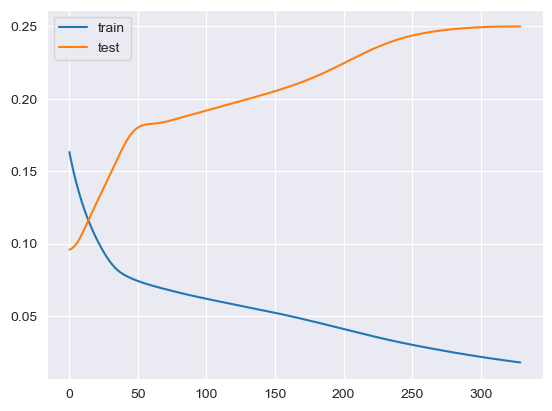

In [40]:
#Visual plot to check if the error is reducing
pyplot.plot(LSTMModel_fit.history['loss'], label='train')
pyplot.plot(LSTMModel_fit.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [41]:
error_Training_LSTM = mean_squared_error(Y_train_LSTM, LSTMModel.predict(X_train_LSTM))
predicted = LSTMModel.predict(X_test_LSTM)
error_Test_LSTM = mean_squared_error(Y_test,predicted)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [42]:
test_results.append(error_Test_ARIMA)
test_results.append(error_Test_LSTM)

train_results.append(error_Training_ARIMA)
train_results.append(error_Training_LSTM)

names.append("ARIMA")
names.append("LSTM")

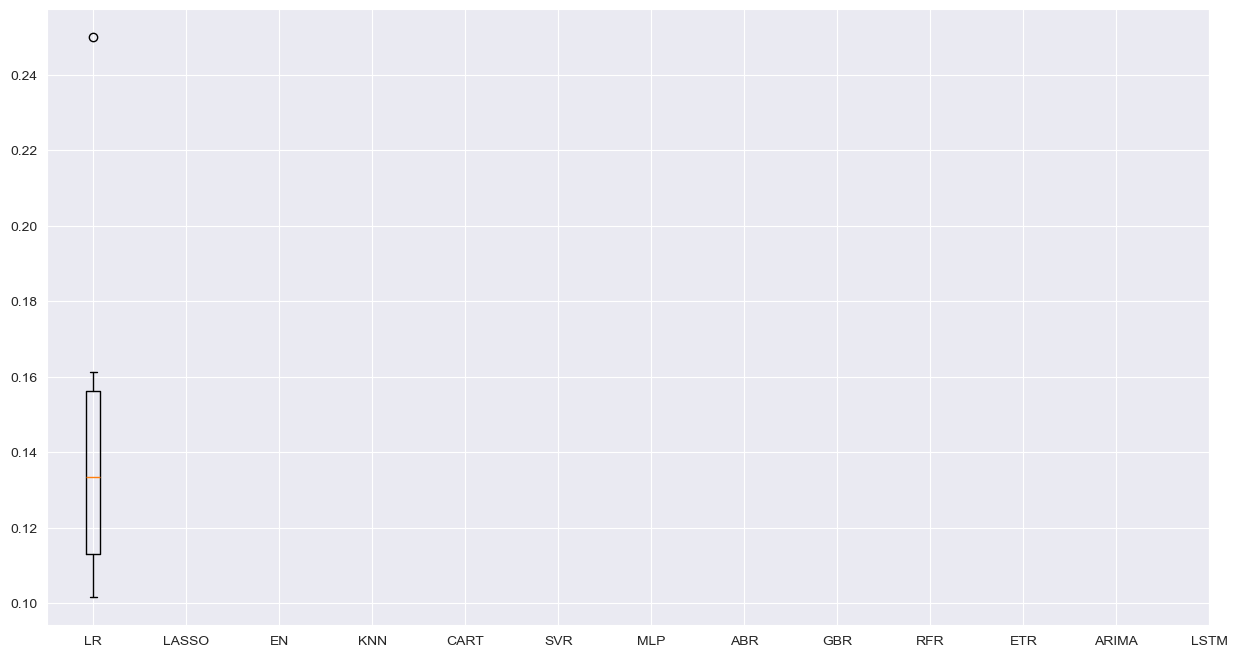

In [43]:
# compare algorithms
fig = pyplot.figure()
ax = fig.add_subplot(111)

# Création du boxplot
pyplot.boxplot(test_results)

# Configuration explicite des ticks et des étiquettes
ax.set_xticks(range(1, len(test_results) + 1))  # Définit les positions des ticks (1, 2, ..., n)
ax.set_xticklabels(names)  # Définit les étiquettes pour ces ticks

# Ajustement de la taille de la figure pour qu'elle soit propre
fig.set_size_inches(15, 8)

# Affichage du graphique
pyplot.show()



In [44]:
# 1. Grid search : LinearRegression
'''
fit_intercept : boolean, optional, default True
    whether to calculate the intercept for this model. If set
    to False, no intercept will be used in calculations
    (e.g. data is expected to be already centered).
'''
# Define your hyperparameters, model, and scoring
param_grid = {'fit_intercept': [True, False]}
model = LinearRegression()
scoring = 'r2'  # Example scoring metric, replace with your own
num_folds = 5
seed = 42  # Replace with your own random seed

# Enable shuffling while defining KFold
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)

# Perform GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
# Fit your model (X_train and Y_train should be defined earlier in your code)
grid_result = grid.fit(X_train, Y_train)

# Output the best parameters and score
print(f"Best Parameters: {grid_result.best_params_}")
print(f"Best Score: {grid_result.best_score_}")


Best Parameters: {'fit_intercept': False}
Best Score: 0.2911909548948439


In [45]:
'''
alpha : float, optional
    Constant that multiplies the L1 term. Defaults to 1.0.
    ``alpha = 0`` is equivalent to an ordinary least square, solved
    by the :class:`LinearRegression` object. For numerical
    reasons, using ``alpha = 0`` with the ``Lasso`` object is not advised.
    Given this, you should use the :class:`LinearRegression` object.
'''
# Paramètres pour la recherche
param_grid = {'alpha': [0.01, 0.1, 0.3, 0.7, 1, 1.5, 3, 5]}
model = Lasso()

# Configuration de KFold avec mélange
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)

# Recherche de la meilleure combinaison de paramètres
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)

# Résultats
print(f"Meilleur score: {grid_result.best_score_}")
print(f"Meilleurs paramètres: {grid_result.best_params_}")



Meilleur score: 0.28062356674975725
Meilleurs paramètres: {'alpha': 0.01}


In [46]:
# 3. Grid Search : ElasticNet
'''
alpha : float, optional
    Constant that multiplies the penalty terms. Defaults to 1.0.
    See the notes for the exact mathematical meaning of this
    parameter.``alpha = 0`` is equivalent to an ordinary least square,
    solved by the :class:`LinearRegression` object. For numerical
    reasons, using ``alpha = 0`` with the ``Lasso`` object is not advised.
    Given this, you should use the :class:`LinearRegression` object.

l1_ratio : float
    The ElasticNet mixing parameter, with ``0 <= l1_ratio <= 1``. For
    ``l1_ratio = 0`` the penalty is an L2 penalty. ``For l1_ratio = 1`` it
    is an L1 penalty.  For ``0 < l1_ratio < 1``, the penalty is a
    combination of L1 and L2.
'''
# Configuration initiale
num_folds = 5
seed = 42
scoring = 'r2'

# Définir la grille des paramètres
param_grid = {'alpha': [0.01, 0.1, 0.3, 0.7, 1, 1.5, 3, 5],
              'l1_ratio': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 0.99]}

# Modèle ElasticNet
model = ElasticNet()

# Correction : shuffle=True pour activer l'utilisation de random_state
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)

# Recherche par grille
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print(f"Best parameters: {grid_result.best_params_}")
print(f"Best score: {grid_result.best_score_}")


Best parameters: {'alpha': 0.1, 'l1_ratio': 0.01}
Best score: 0.31638489288936567


In [47]:
# 4. Grid search : KNeighborsRegressor
'''
n_neighbors : int, optional (default = 5)
    Number of neighbors to use by default for :meth:`kneighbors` queries.
'''
# Exemple d'hyperparamètres
param_grid = {'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]}
num_folds = 5  # Définir le nombre de splits
seed = 42  # Assurez la reproductibilité
scoring = 'neg_mean_squared_error'

# Définir le modèle et la validation croisée
model = KNeighborsRegressor()
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)

# Ajustez le modèle aux données d'entraînement
grid_result = grid.fit(X_train, Y_train)

# Affichez les résultats
print(f"Meilleur score: {grid_result.best_score_}")
print(f"Meilleurs paramètres: {grid_result.best_params_}")


Meilleur score: -0.10143021923504081
Meilleurs paramètres: {'n_neighbors': 17}


In [48]:
# 5. Grid search : DecisionTreeRegressor
'''
min_samples_split : int, float, optional (default=2)
    The minimum number of samples required to split an internal node:

    - If int, then consider `min_samples_split` as the minimum number.
    - If float, then `min_samples_split` is a percentage and
      `ceil(min_samples_split * n_samples)` are the minimum
      number of samples for each split.
'''
# Paramètres
param_grid = {'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10]}
model = DecisionTreeRegressor()

# Définir les paramètres pour KFold
num_folds = 5
seed = 42

# Correction : Activer shuffle pour utiliser random_state
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)

# Configuration de GridSearchCV
scoring = 'neg_mean_squared_error'  # Exemple de scoring, vous pouvez adapter si nécessaire
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)

# Affichage des résultats
print(f"Meilleur score : {grid_result.best_score_}")
print(f"Meilleurs paramètres : {grid_result.best_params_}")



Meilleur score : -0.15693647088908216
Meilleurs paramètres : {'min_samples_split': 8}


In [49]:
# 6. Grid search : SVR
'''
C : float, optional (default=1.0)
    Penalty parameter C of the error term.

epsilon : float, optional (default=0.1)
     Epsilon in the epsilon-SVR model. It specifies the epsilon-tube
     within which no penalty is associated in the training loss function
     with points predicted within a distance epsilon from the actual
     value.
gamma : float, optional (default='auto')
    Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.
    If gamma is 'auto' then 1/n_features will be used instead.
'''
# Exemple de paramètres
num_folds = 5
seed = 42
scoring = 'neg_mean_squared_error'
param_grid = {'C': [0.1, 1, 10], 'epsilon': [0.01, 0.1, 1]}

# Modèle
model = SVR()

# Correction: shuffle=True avec random_state
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)

# Recherche en grille
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)

print(f"Meilleurs paramètres : {grid_result.best_params_}")


Meilleurs paramètres : {'C': 0.1, 'epsilon': 0.1}


In [50]:
# 7. Grid search : MLPRegressor
'''
hidden_layer_sizes : tuple, length = n_layers - 2, default (100,)
    The ith element represents the number of neurons in the ith
    hidden layer.
'''
# Paramètres
num_folds = 5
seed = 42
param_grid = {'hidden_layer_sizes': [(20,), (50,), (20, 20), (20, 30, 20)]}
model = MLPRegressor()

# KFold avec mélange des données
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)

# Configuration de la recherche de grille
scoring = 'r2'
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)

# Entraînement
grid_result = grid.fit(X_train, Y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.242702 using {'hidden_layer_sizes': (50,)}
0.217941 (0.208049) with: {'hidden_layer_sizes': (20,)}
0.242702 (0.307613) with: {'hidden_layer_sizes': (50,)}
0.221345 (0.302569) with: {'hidden_layer_sizes': (20, 20)}
-0.035097 (0.286547) with: {'hidden_layer_sizes': (20, 30, 20)}


In [51]:
# 8. Grid search : RandomForestRegressor
'''
n_estimators : integer, optional (default=10)
    The number of trees in the forest.
'''
# Définition des paramètres
num_folds = 5
seed = 42
scoring = "neg_mean_squared_error"
param_grid = {'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400]}

# Modèle
model = RandomForestRegressor()

# Validation croisée KFold avec mélange
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)

# GridSearch
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.095970 using {'n_estimators': 100}
-0.100165 (0.006579) with: {'n_estimators': 50}
-0.095970 (0.005658) with: {'n_estimators': 100}
-0.099436 (0.005917) with: {'n_estimators': 150}
-0.100662 (0.006810) with: {'n_estimators': 200}
-0.097835 (0.006260) with: {'n_estimators': 250}
-0.099294 (0.007892) with: {'n_estimators': 300}
-0.097214 (0.004400) with: {'n_estimators': 350}
-0.097659 (0.006710) with: {'n_estimators': 400}


In [52]:

# 9. Grid search : GradientBoostingRegressor
'''
n_estimators:

    The number of boosting stages to perform. Gradient boosting
    is fairly robust to over-fitting so a large number usually
    results in better performance.
'''
# Définir les paramètres du modèle
param_grid = {'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400]}
seed = 42  # Définir une graine aléatoire pour des résultats reproductibles
num_folds = 5  # Nombre de sous-échantillons pour la validation croisée

# Configurer le modèle
model = GradientBoostingRegressor(random_state=seed)

# Correction : activer le mélange des données
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)

# Faire une recherche par grille
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=kfold)

# Ajuster le modèle avec les données (champs X_train et Y_train requis)
grid_result = grid.fit(X_train, Y_train)



print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.101984 using {'n_estimators': 50}
-0.101984 (0.021460) with: {'n_estimators': 50}
-0.102212 (0.024218) with: {'n_estimators': 100}
-0.102555 (0.024281) with: {'n_estimators': 150}
-0.102330 (0.024224) with: {'n_estimators': 200}
-0.102183 (0.024241) with: {'n_estimators': 250}
-0.102142 (0.024235) with: {'n_estimators': 300}
-0.102118 (0.024248) with: {'n_estimators': 350}
-0.102123 (0.024257) with: {'n_estimators': 400}


In [53]:
# 10. Grid search : ExtraTreesRegressor
'''
n_estimators : integer, optional (default=10)
    The number of trees in the forest.
'''

# Définir les valeurs fixes
seed = 42
num_folds = 5
scoring = 'neg_mean_squared_error'

# Vos paramètres et le modèle
param_grid = {'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400]}
model = ExtraTreesRegressor(random_state=seed)

# Corriger KFold : Activer shuffle pour pouvoir définir random_state
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)

# GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)


print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.095032 using {'n_estimators': 350}
-0.097340 (0.006348) with: {'n_estimators': 50}
-0.095148 (0.008582) with: {'n_estimators': 100}
-0.096567 (0.007780) with: {'n_estimators': 150}
-0.096775 (0.008235) with: {'n_estimators': 200}
-0.096342 (0.008418) with: {'n_estimators': 250}
-0.095091 (0.008546) with: {'n_estimators': 300}
-0.095032 (0.008907) with: {'n_estimators': 350}
-0.095814 (0.008967) with: {'n_estimators': 400}


In [54]:
# 11. Grid search : AdaBoostRegre
'''
n_estimators : integer, optional (default=50)
    The maximum number of estimators at which boosting is terminated.
    In case of perfect fit, the learning procedure is stopped early.

learning_rate : float, optional (default=1.)
    Learning rate shrinks the contribution of each regressor by
    ``learning_rate``. There is a trade-off between ``learning_rate`` and
    ``n_estimators``.
'''

print("Type de X_train :", type(X_train))
print("Dimensions de X_train :", X_train.shape if hasattr(X_train, 'shape') else "Aucune forme détectée")
print("Type de Y_train :", type(Y_train))
print("Dimensions de Y_train :", Y_train.shape if hasattr(Y_train, 'shape') else "Aucune forme détectée")


# Exemple de code pour reformater les données
X_train = np.asarray(X_train)  # S'assurez que c'est un tableau numpy
Y_train = np.asarray(Y_train)

# Si les dimensions ne correspondent pas, affichez un message d'erreur
if len(X_train.shape) != 2:
    raise ValueError("X_train doit avoir deux dimensions : (n_samples, n_features).")
if len(Y_train.shape) != 1:
    raise ValueError("Y_train doit être un vecteur de longueur n_samples.")



# Configuration du modèle et du GridSearchCV
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)

# Entraînement du modèle
grid_result = grid.fit(X_train, Y_train)

# Affichage des résultats
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']

stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Type de X_train : <class 'pandas.core.frame.DataFrame'>
Dimensions de X_train : (99, 11)
Type de Y_train : <class 'pandas.core.series.Series'>
Dimensions de Y_train : (99,)
Best: -0.095032 using {'n_estimators': 350}
-0.097340 (0.006348) with: {'n_estimators': 50}
-0.095148 (0.008582) with: {'n_estimators': 100}
-0.096567 (0.007780) with: {'n_estimators': 150}
-0.096775 (0.008235) with: {'n_estimators': 200}
-0.096342 (0.008418) with: {'n_estimators': 250}
-0.095091 (0.008546) with: {'n_estimators': 300}
-0.095032 (0.008907) with: {'n_estimators': 350}
-0.095814 (0.008967) with: {'n_estimators': 400}


In [55]:
# 12. Grid search : KerasNNRegressor
'''
nn_shape : tuple, length = n_layers - 2, default (100,)
    The ith element represents the number of neurons in the ith
    hidden layer.
'''
#Add Deep Learning Regressor
if ( EnableDeepLearningRegreesorFlag == 1):
    param_grid={'nn_shape': [(20,), (50,), (20,20), (20, 30, 20)]}
    model = KerasNNRegressor()
    kfold = KFold(n_splits=num_folds, random_state=seed)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid_result = grid.fit(X_train, Y_train)
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

In [56]:
#Grid Search for LSTM Model

# evaluate an LSTM model for a given order (p,d,q)
def evaluate_LSTM_model(neurons=12, learn_rate = 0.01, momentum=0):
    #predicted = list()
    LSTMModel = create_LSTMmodel(neurons, learn_rate, momentum)
    LSTMModel_fit = LSTMModel.fit(X_train_LSTM, Y_train_LSTM,epochs=50, batch_size=72, verbose=0, shuffle=False)
    predicted = LSTMModel.predict(X_validation_LSTM)
    error = mean_squared_error(predicted, Y_validation)
    return error

# evaluate combinations of different variables of LSTM Model
def evaluate_combinations_LSTM(neurons, learn_rate, momentum):
    best_score, best_cfg = float("inf"), None
    for n in neurons:
        for l in learn_rate:
            for m in momentum:
                combination = (n,l,m)
                try:
                    mse = evaluate_LSTM_model(n,l,m)
                    if mse < best_score:
                        best_score, best_cfg = mse, combination
                    print('LSTM%s MSE=%.7f' % (combination,mse))
                except:
                    continue
    print('Best LSTM%s MSE=%.7f' % (best_cfg, best_score))

# evaluate parameters
neurons = [1, 5]
learn_rate = [0.001, 0.3]
momentum = [0.0, 0.9]
#Other Parameters can be modified as well
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
warnings.filterwarnings("ignore")
evaluate_combinations_LSTM(neurons,learn_rate,momentum)

Best LSTMNone MSE=inf


In [57]:
#Grid Search for LSTM Model

# evaluate an LSTM model for a given order (p,d,q)
def evaluate_LSTM_model(neurons=12, learn_rate = 0.01, momentum=0):
    #predicted = list()
    LSTMModel = create_LSTMmodel(neurons, learn_rate, momentum)
    LSTMModel_fit = LSTMModel.fit(X_train_LSTM, Y_train_LSTM,epochs=50, batch_size=72, verbose=0, shuffle=False)
    predicted = LSTMModel.predict(X_validation_LSTM)
    error = mean_squared_error(predicted, Y_validation)
    return error

# evaluate combinations of different variables of LSTM Model
def evaluate_combinations_LSTM(neurons, learn_rate, momentum):
    best_score, best_cfg = float("inf"), None
    for n in neurons:
        for l in learn_rate:
            for m in momentum:
                combination = (n,l,m)
                try:
                    mse = evaluate_LSTM_model(n,l,m)
                    if mse < best_score:
                        best_score, best_cfg = mse, combination
                    print('LSTM%s MSE=%.7f' % (combination,mse))
                except:
                    continue
    print('Best LSTM%s MSE=%.7f' % (best_cfg, best_score))

# evaluate parameters
neurons = [1, 5]
learn_rate = [0.001, 0.3]
momentum = [0.0, 0.9]
#Other Parameters can be modified as well
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
warnings.filterwarnings("ignore")
evaluate_combinations_LSTM(neurons,learn_rate,momentum)

Best LSTMNone MSE=inf


In [58]:
# prepare model
#scaler = StandardScaler().fit(X_train)
#rescaledX = scaler.transform(X_train)
model = RandomForestRegressor(n_estimators=250) # rbf is default kernel
model.fit(X_train, Y_train)

RandomForestRegressor(n_estimators=250)

In [59]:
# estimate accuracy on validation set
# transform the validation dataset
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
#rescaledValidationX = scaler.transform(X_validation)

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=0.2, random_state=42)


predictions = model.predict(X_validation)
print(mean_squared_error(Y_validation, predictions))
print(r2_score(Y_validation, predictions))

0.03290860296552095
0.6208529076379643


In [60]:
predictions

array([ 0.07355138, -0.07457871, -0.08646786, -0.16058718,  0.01697277,
        0.00676792,  0.0169915 , -0.02739075, -0.1629115 ,  0.13740771,
       -0.0269963 ,  0.32127616,  0.04901724, -0.00718545, -0.1811656 ,
        0.57427795,  0.33332382,  0.10578369, -0.06353864, -0.02863786,
       -0.07966713, -0.08342289, -0.27843107, -0.16337233,  0.42122048])

[0.06362774 0.07490758 0.04278064 0.03725071 0.02046492 0.04584783
 0.08029879 0.30274948 0.06826682 0.11600683 0.14779865]


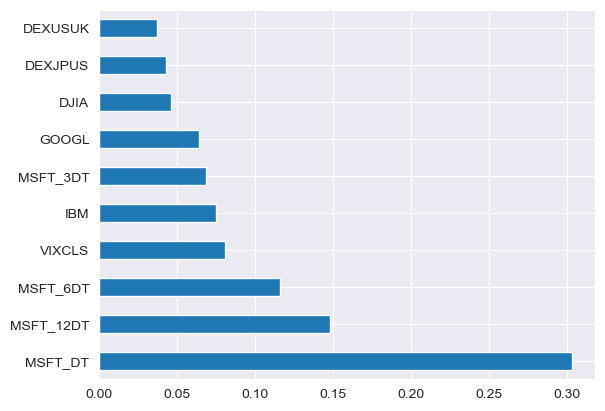

In [61]:
import pandas as pd
import numpy as np
model = RandomForestRegressor()
model.fit(X_train,Y_train)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based regressors
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
pyplot.show()

In [62]:
# Save Model Using Pickle


# save the model to disk
filename = 'finalized_model.sav'
dump(model, open(filename, 'wb'))

In [63]:
# some time later...
# load the model from disk
loaded_model = load(open(filename, 'rb'))
# estimate accuracy on validation set
#rescaledValidationX = scaler.transform(X_validation) #in case the data is scaled.
#predictions = model.predict(rescaledValidationX)

# Convertir le DataFrame en array NumPy, puis appliquer reshape
X_validation_flattened = X_validation.values.reshape(X_validation.shape[0], -1)

# Utiliser les données transformées pour les prédictions
predictions = model.predict(X_validation_flattened)



# = model.predict(X_validation_flattened)
result = mean_squared_error(Y_validation, predictions)
print(result)

0.09733222640195315
